## 1. Imports

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

#Scaling
from sklearn.preprocessing import MinMaxScaler

 #Correlation Heatmap
from matplotlib.colors import LinearSegmentedColormap

#Statistical Test
from scipy import stats
from sklearn.impute import SimpleImputer

#Models
from sklearn.linear_model import LogisticRegression
from sklearn.feature_selection import RFE
from sklearn.model_selection import train_test_split

from sklearn.model_selection import KFold, RepeatedKFold, cross_val_score
from sklearn.neural_network import MLPClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression, RidgeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, classification_report
from sklearn.model_selection import train_test_split, cross_val_score

from sklearn.linear_model import Ridge

pd.set_option('display.max_columns', None)

In [3]:
# Read the dataset
X_train_encoded = pd.read_csv('../project_data/X_train_encoded.csv', delimiter=',', index_col=0)
X_val_encoded = pd.read_csv('../project_data/X_val_encoded.csv', delimiter=',', index_col=0)

y_train = pd.read_csv('../project_data/y_train.csv',delimiter=',', index_col=0)
y_val= pd.read_csv('../project_data/y_val.csv', delimiter=',', index_col=0)

X_test_encoded = pd.read_csv('../project_data/X_test_encoded.csv',index_col=0)

In [4]:
# Binary classification dataset
X_train_encoded_bin = pd.read_csv('../project_data/X_train_encoded_binary.csv', delimiter=',', index_col=0)
X_val_encoded_bin = pd.read_csv('../project_data/X_val_encoded_binary.csv', delimiter=',', index_col=0)

y_train_bin = pd.read_csv('../project_data/y_train_binary.csv',delimiter=',', index_col=0)
y_val_bin= pd.read_csv('../project_data/y_val_binary.csv', delimiter=',', index_col=0)

X_test_encoded_bin = pd.read_csv('../project_data/X_test_encoded_binary.csv',index_col=0)

## 2. Preparing the data

### 2.1 Encoding multiclass target

In [5]:
claim_injury_type_mapping = {
    '4. TEMPORARY': 4,
    '2. NON-COMP':2,
    '5. PPD SCH LOSS': 5,
    '3. MED ONLY': 3,
    '6. PPD NSL': 6,
    '1. CANCELLED': 1,
    '8. DEATH':8,
    '7. PTD': 7
}

y_train_encoded = y_train['Claim Injury Type'].map(claim_injury_type_mapping)
y_val_encoded = y_val['Claim Injury Type'].map(claim_injury_type_mapping)

In [6]:
y_train_squeezed = y_train.squeeze()  # Converts a DataFrame with one column to a Series

In [7]:
# Assuming y_train is your target and X_train_encoded is the corresponding features
# The value 1 represents the "non comp" class in y_train

# Create a mask for rows not equal to 1
mask = y_train_encoded != 2

# Filter X_train_encoded and y_train based on the mask
X_train_minority = X_train_encoded[mask]
y_train_minority = y_train_encoded[mask]

# Verify the shapes of the new filtered datasets
print("Shape of X_train_minority:", X_train_minority.shape)
print("Shape of y_train_minority:", y_train_minority.shape)

# Check unique classes in the target to confirm "non comp" is removed
print("Classes in y_train_minority:", y_train_minority)

Shape of X_train_minority: (193852, 59)
Shape of y_train_minority: (193852,)
Classes in y_train_minority: Claim Identifier
5506797    5
5520188    5
5748412    3
5653867    4
6013635    4
          ..
5506601    5
5575626    4
5495278    3
5956257    5
5844843    1
Name: Claim Injury Type, Length: 193852, dtype: int64


### 2.2 Separate Numerical and Categorical

#### 2.2.1  Binary separation

In [21]:
num_columns_bin = ['Age at Injury', 
                   'IME-4 Count', 
                   'Number of Dependents',

                   'Industry Code_encoded_0',
                   'Industry Code_encoded_1', 

                   'WCIO Cause of Injury Code_encoded_0',
                   'WCIO Cause of Injury Code_encoded_1',

                   'WCIO Nature of Injury Code_encoded_0',
                   'WCIO Nature of Injury Code_encoded_1',

                   'WCIO Part Of Body Code_encoded_0', 
                   'WCIO Part Of Body Code_encoded_1',

                   'Industry Code_freq', 
                   'WCIO Cause of Injury Code_freq',
                   'WCIO Nature of Injury Code_freq',
                   'WCIO Part Of Body Code_freq',
                   'Carrier Type Imputed_freq', 
                   'Carrier Name_freq',

                   'Accident Datemonth',
                   'Accident Date_Season_Spring', 
                   'Accident Date_Season_Summer',
                   'Accident Date_Season_Winter',

                   'Days_between_Assembly Date_Accident Date_log',
                   'Days_between_C-2 Date Imputed_Accident Date_log',
                   'Average Weekly Wage Imputed_log']

cat_columns_bin = ['Carrier Type_Self-insured Private Entity',
                   'Carrier Type_Self-insured Public Entity', 
                   'Carrier Type_Special Funds',
                   'Carrier Type_State Insurance Fund', 
                   'Carrier Type_nan',   
                   'C-3 Date_nabinary', 
                   'Average Weekly Wage_nabinary',
                   'First Hearing Date_nabinary',
                   'Alternative Dispute Resolution_binary',
                   'COVID-19 Indicator_binary',
                   'Attorney/Representative_binary']

# Create subsets
X_train_num_bin = X_train_encoded_bin[num_columns_bin]
X_train_cat_bin = X_train_encoded_bin[cat_columns_bin]

X_val_num_bin = X_val_encoded_bin[num_columns_bin]
X_val_cat_bin = X_val_encoded_bin[cat_columns_bin]

X_test_num_bin=X_test_encoded_bin[num_columns_bin]
X_test_cat_bin=X_test_encoded_bin[cat_columns_bin]

#### 2.2.2 Multiclass separation

> Drop the ones associated the the target class 2. NON-COMP

In [17]:
# Drop features associated with "non comp" in their name
columns_to_drop = [col for col in X_train_encoded.columns if "non-comp" in col.lower()]

# Drop the columns from the dataset
X_train_encoded_dropped = X_train_encoded.drop(columns=columns_to_drop)
X_val_encoded_dropped = X_val_encoded.drop(columns=columns_to_drop)  # If you have validation data
X_test_encoded_dropped = X_test_encoded.drop(columns=columns_to_drop)  # If you have test data

# Verify the remaining columns
print("Remaining columns after dropping 'non comp' features:")
print(len(X_train_encoded_dropped.columns))

Remaining columns after dropping 'non comp' features:
55


In [19]:
num_columns = ['Age at Injury', 
               'IME-4 Count', 
               'Number of Dependents',
               
               'Industry Code_encoded_5. PPD SCH LOSS',
               'Industry Code_encoded_3. MED ONLY',
               'Industry Code_encoded_4. TEMPORARY',
               'Industry Code_encoded_1. CANCELLED', 
               'Industry Code_encoded_8. DEATH',
               'Industry Code_encoded_6. PPD NSL', 
               'Industry Code_encoded_7. PTD',
               
               'WCIO Cause of Injury Code_encoded_5. PPD SCH LOSS',
               'WCIO Cause of Injury Code_encoded_3. MED ONLY',
               'WCIO Cause of Injury Code_encoded_4. TEMPORARY',
               'WCIO Cause of Injury Code_encoded_1. CANCELLED',
               'WCIO Cause of Injury Code_encoded_8. DEATH',
               'WCIO Cause of Injury Code_encoded_6. PPD NSL',
               'WCIO Cause of Injury Code_encoded_7. PTD',
               
               'WCIO Nature of Injury Code_encoded_5. PPD SCH LOSS',
               'WCIO Nature of Injury Code_encoded_3. MED ONLY',
               'WCIO Nature of Injury Code_encoded_4. TEMPORARY',
               'WCIO Nature of Injury Code_encoded_1. CANCELLED',
               'WCIO Nature of Injury Code_encoded_8. DEATH',
               'WCIO Nature of Injury Code_encoded_6. PPD NSL',
               'WCIO Nature of Injury Code_encoded_7. PTD',
               
               'WCIO Part Of Body Code_encoded_5. PPD SCH LOSS',
               'WCIO Part Of Body Code_encoded_3. MED ONLY',
               'WCIO Part Of Body Code_encoded_4. TEMPORARY',
               'WCIO Part Of Body Code_encoded_1. CANCELLED',
               'WCIO Part Of Body Code_encoded_8. DEATH',
               'WCIO Part Of Body Code_encoded_6. PPD NSL',
               'WCIO Part Of Body Code_encoded_7. PTD',
               
               'Industry Code_freq',
               'WCIO Cause of Injury Code_freq', 
               'WCIO Nature of Injury Code_freq',
               'WCIO Part Of Body Code_freq', 
               'Carrier Type Imputed_freq',
               'Carrier Name_freq',
               
               'Accident Datemonth',
               'Accident Date_Season_Spring', 
               'Accident Date_Season_Summer',
               'Accident Date_Season_Winter',

               'Days_between_Assembly Date_Accident Date_log',
               'Days_between_C-2 Date Imputed_Accident Date_log',
               'Average Weekly Wage Imputed_log']

cat_columns =['Carrier Type_Self-insured Private Entity',
               'Carrier Type_Self-insured Public Entity', 
               'Carrier Type_Special Funds',
               'Carrier Type_State Insurance Fund', 
               'Carrier Type_nan',
               'C-3 Date_nabinary', 
               'Average Weekly Wage_nabinary',
               'First Hearing Date_nabinary',
               'Alternative Dispute Resolution_binary',
               'COVID-19 Indicator_binary',
               'Attorney/Representative_binary']


# Create subsets
X_train_num = X_train_encoded[num_columns]
X_train_cat = X_train_encoded[cat_columns]

X_val_num = X_val_encoded[num_columns]
X_val_cat = X_val_encoded[cat_columns]

X_test_num=X_test_encoded[num_columns]
X_test_cat=X_test_encoded[cat_columns]

## 3. Scaling

### 3.1 Scale non-binary

In [23]:
scaler = MinMaxScaler().fit(X_train_num)
X_train_num_scaled = scaler.transform(X_train_num)
# print("Parameters fitted:")
# for feature, min_val, max_val in zip(X_train_num.columns, scaler.data_min_, scaler.data_max_):
    # print(f"Variable: {feature} | Min: {min_val} | Max: {max_val}")

# Convert the array to a pandas dataframe
X_train_num_scaled = pd.DataFrame(X_train_num_scaled, columns = X_train_num.columns).set_index(X_train_encoded.index)
# X_train_num_scaled.describe().round(2)

In [24]:
X_val_num_scaled = scaler.transform(X_val_num)
X_val_num_scaled = pd.DataFrame(X_val_num_scaled, columns = X_val_num.columns).set_index(X_val_encoded.index)
# X_val_num_scaled.describe().round(2)

In [25]:
X_test_num_scaled = scaler.transform(X_test_num)
X_test_num_scaled = pd.DataFrame(X_test_num_scaled, columns = X_test_num.columns).set_index(X_test_encoded.index)
# X_test_num_scaled.describe().round(2)

### 3.2 Scale binary

In [26]:
scaler = MinMaxScaler().fit(X_train_num_bin)
X_train_num_scaled_bin = scaler.transform(X_train_num_bin)
# print("Parameters fitted:")
# for feature, min_val, max_val in zip(X_train_num.columns, scaler.data_min_, scaler.data_max_):
    # print(f"Variable: {feature} | Min: {min_val} | Max: {max_val}")

# Convert the array to a pandas dataframe
X_train_num_scaled_bin = pd.DataFrame(X_train_num_scaled_bin, columns = X_train_num_bin.columns).set_index(X_train_encoded_bin.index)
# X_train_num_scaled.describe().round(2)

In [27]:
X_val_num_scaled_bin = scaler.transform(X_val_num_bin)
X_val_num_scaled_bin = pd.DataFrame(X_val_num_scaled_bin, columns = X_val_num_bin.columns).set_index(X_val_encoded_bin.index)
# X_val_num_scaled.describe().round(2)

In [28]:
X_test_num_scaled_bin = scaler.transform(X_test_num_bin)
X_test_num_scaled_bin = pd.DataFrame(X_test_num_scaled_bin, columns = X_test_num_bin.columns).set_index(X_test_encoded_bin.index)
# X_test_num_scaled.describe().round(2)

## 4. Binary: Feature selection

><strong style="color:#6fa8dc">Add this to a separate python file</strong>


### 4.1 Filter Categorical Features

In [54]:
# squeeze the y_train_bin
y_train_bin = y_train_bin.squeeze()

#### 4.1.1 Chi-square

In [32]:
import pandas as pd  # For creating and handling DataFrames
import numpy as np  # For numerical operations
from sklearn.feature_selection import chi2  # For Chi-square test
from scipy.stats import chi2_contingency  # For Cramér's V calculation

In [33]:
def cramers_v(X, y):
    """
    Calculate Cramér's V for a categorical feature and a target.
    :param X: Categorical feature (Pandas Series or array-like)
    :param y: Target variable (Pandas Series or array-like)
    :return: Cramér's V value
    """
    # Create the contingency table
    df_contingency = pd.crosstab(X, y)

    # Perform chi-square test
    chi2, p, dof, expected = chi2_contingency(df_contingency.values)

    # Calculate Cramér's V
    n = df_contingency.sum().sum()  # Total number of observations
    min_dim = min(df_contingency.shape) - 1  # Min between number of rows and columns - 1
    cramers_v = np.sqrt(chi2 / (n * min_dim))  # Cramér's V formula

    return cramers_v


In [ ]:
# Perform Chi-square test
chi2_values, p_values = chi2(X_train_cat_bin, y_train_bin)

# Create DataFrame for Chi-square results
chi2_results = pd.DataFrame({
    'Column': X_train_cat_bin.columns,
    'Chi2': chi2_values.round(5),
    'p-value': p_values.round(5)
})

# Calculate Cramér's V for binary target
cramers_v_values = []
for var in X_train_cat_bin.columns:
    v = cramers_v(X_train_cat_bin[var], y_train_bin)
    cramers_v_values.append(v)

# Add Cramér's V to DataFrame
chi2_results['Cramér\'s V'] = cramers_v_values

# Filter important features
chi2_important_features = chi2_results[(chi2_results['p-value'] < 0.05) & (chi2_results['Cramér\'s V'] >= 0.1)]

list_features_chi2_cramer = chi2_important_features['Column'].values

print(chi2_important_features)

                               Column         Chi2  p-value  Cramér's V
3   Carrier Type_State Insurance Fund   4215.72148      0.0    0.114906
5                   C-3 Date_nabinary  23953.69374      0.0    0.429801
6        Average Weekly Wage_nabinary  86212.24203      0.0    0.770968
7         First Hearing Date_nabinary  25813.45742      0.0    0.498054
10     Attorney/Representative_binary  78009.76607      0.0    0.535952


#### 4.1.2 Mutual Information

In [67]:
from sklearn.feature_selection import mutual_info_classif

# Calculate mutual information for categorical features
mi_scores = mutual_info_classif(X_train_cat_bin, y_train_bin, discrete_features=True)

# Create DataFrame of results
mi_results = pd.DataFrame({
    'Feature': X_train_cat_bin.columns,
    'Mutual Information': mi_scores
}).sort_values(by='Mutual Information', ascending=False)

mi_results


,Feature,Mutual Information
6,Average Weekly Wage_nabinary,0.370264
10,Attorney/Representative_binary,0.157423
7,First Hearing Date_nabinary,0.138322
5,C-3 Date_nabinary,0.096962
3,Carrier Type_State Insurance Fund,0.006636
8,Alternative Dispute Resolution_binary,0.002901
9,COVID-19 Indicator_binary,0.002820
0,Carrier Type_Self-insured Private Entity,0.000811
4,Carrier Type_nan,0.000742
1,Carrier Type_Self-insured Public Entity,0.000223


In [ ]:

mi_important_features = mi_results[mi_results['Mutual Information'] > 0.05]

list_features_mi = mi_results[mi_results['Mutual Information'] > 0.05]['Feature'].values

print(mi_important_features)

#### 4.1.3 Filtered features

In [44]:
# Select features that appear in at least one of the important feature sets
selected_features = list(set(list_features_chi2_cramer) | set(list_features_mi)) 
selected_features

['Attorney/Representative_binary',
 'Carrier Type_State Insurance Fund',
 'First Hearing Date_nabinary',
 'C-3 Date_nabinary',
 'Average Weekly Wage_nabinary']

In [45]:
# Keep only selected important features in the datasets
X_train_cat_filtered_bin = X_train_cat_bin[selected_features]
X_val_cat_filtered_bin = X_val_cat_bin[selected_features]
X_test_cat_filtered_bin = X_test_cat_bin[selected_features]

### 4.2 Filter Numerical Features

#### 4.2.1 Univariate variance

In [46]:
X_train_num_scaled_bin.var().sort_values(ascending=False)

Accident Date_Season_Summer                        0.190598
Accident Date_Season_Winter                        0.190024
Accident Date_Season_Spring                        0.181228
Average Weekly Wage Imputed_log                    0.158004
Carrier Name_freq                                  0.142667
WCIO Nature of Injury Code_freq                    0.136735
Industry Code_freq                                 0.123001
Number of Dependents                               0.111300
Carrier Type Imputed_freq                          0.103530
Accident Datemonth                                 0.099293
WCIO Part Of Body Code_freq                        0.098325
Industry Code_encoded_1                            0.096085
Industry Code_encoded_0                            0.096085
WCIO Cause of Injury Code_freq                     0.080853
WCIO Part Of Body Code_encoded_1                   0.057635
WCIO Part Of Body Code_encoded_0                   0.057635
Age at Injury                           

> None with variance zero

#### 4.2.2 Spearman Correlation

In [48]:
# Step 1: Calculate the Spearman correlation matrix for numerical features
cor_spearman = X_train_num_scaled_bin.corr(method='spearman')

# Step 2: Flatten the correlation matrix and reset the index
correlation_pairs = cor_spearman.unstack().reset_index()

# Step 3: Rename columns for clarity
correlation_pairs.columns = ['Feature_1', 'Feature_2', 'Correlation']

# Step 4: Filter the table for correlations > 0.8 or < -0.8 and exclude self-correlations (diagonal)
strong_correlations = correlation_pairs[
    ((correlation_pairs['Correlation'] > 0.8) | (correlation_pairs['Correlation'] < -0.8)) & 
    (correlation_pairs['Feature_1'] != correlation_pairs['Feature_2'])
]

# Step 5: Remove duplicate pairs by keeping only one order
strong_correlations = strong_correlations[
    strong_correlations['Feature_1'] < strong_correlations['Feature_2']
]

# Step 6: Sort by correlation value
strong_correlations = strong_correlations.sort_values(by='Correlation', ascending=False)

# Step 7: Display the table
strong_correlations


,Feature_1,Feature_2,Correlation
526,Days_between_Assembly Date_Accident Date_log,Days_between_C-2 Date Imputed_Accident Date_log,0.954048
76,Industry Code_encoded_0,Industry Code_encoded_1,-1.000000
126,WCIO Cause of Injury Code_encoded_0,WCIO Cause of Injury Code_encoded_1,-1.000000
176,WCIO Nature of Injury Code_encoded_0,WCIO Nature of Injury Code_encoded_1,-1.000000
226,WCIO Part Of Body Code_encoded_0,WCIO Part Of Body Code_encoded_1,-1.000000


> To be expected since it's binary.

In [ ]:
from sklearn.feature_selection import mutual_info_classif

# Compute mutual information between categorical features and target
mutual_info = mutual_info_classif(X_train_num_scaled_bin, y_train_encoded)

# Display features sorted by mutual information
mi_results = pd.DataFrame({
    'Feature': X_train_num_scaled_bin.columns,
    'Mutual Information': mutual_info
}).sort_values(by='Mutual Information', ascending=False)

mi_results

In [72]:
# Assuming `mutual_info` is the result from `mutual_info_classif` function
mi_results = pd.DataFrame({
    'Feature': X_train_num_scaled_bin.columns,
    'Mutual Information': mutual_info
}).sort_values(by='Mutual Information', ascending=False)

# Filter features with Mutual Information > 0.05
mi_important_features = mi_results[mi_results['Mutual Information'] < 0.01]

# Display the important features
print(mi_important_features)


                        Feature  Mutual Information
18  Accident Date_Season_Spring            0.007497
20  Accident Date_Season_Winter            0.005568
19  Accident Date_Season_Summer            0.005405
2          Number of Dependents            0.003554
17           Accident Datemonth            0.003212


#### 4.2.3 Filtered features

In [76]:
# List of features to drop from X_train_num_scaled
num_features_to_drop = [
    'Days_between_C-2 Date Imputed_Accident Date_log',
    'Industry Code_encoded_0',
    'WCIO Cause of Injury Code_encoded_0',
    'WCIO Nature of Injury Code_encoded_0',
    'WCIO Part Of Body Code_encoded_0',
    'Accident Date_Season_Spring',
    'Accident Date_Season_Winter',
    'Accident Date_Season_Summer',
    'Number of Dependents',
    'Accident Datemonth'
    ]

# Drop features
X_train_num_scaled_filtered_bin = X_train_num_scaled_bin.drop(columns=num_features_to_drop)
X_val_num_scaled_filtered_bin = X_val_num_scaled_bin.drop(columns=num_features_to_drop)
X_test_num_scaled_filtered_bin = X_test_num_scaled_bin.drop(columns=num_features_to_drop)

# Verify the remaining columns
print("Remaining features in X_train_num_scaled:", X_train_num_scaled_filtered_bin.columns)


Remaining features in X_train_num_scaled: Index(['Age at Injury', 'IME-4 Count', 'Industry Code_encoded_1',
       'WCIO Cause of Injury Code_encoded_1',
       'WCIO Nature of Injury Code_encoded_1',
       'WCIO Part Of Body Code_encoded_1', 'Industry Code_freq',
       'WCIO Cause of Injury Code_freq', 'WCIO Nature of Injury Code_freq',
       'WCIO Part Of Body Code_freq', 'Carrier Type Imputed_freq',
       'Carrier Name_freq', 'Days_between_Assembly Date_Accident Date_log',
       'Average Weekly Wage Imputed_log'],
      dtype='object')


### 4.3 Combine the filtered datasets

In [77]:
# Combine the filtered datasets
X_train_bin = pd.concat([X_train_cat_filtered_bin, X_train_num_scaled_filtered_bin], axis=1)
X_val_bin =  pd.concat([X_val_cat_filtered_bin, X_val_num_scaled_filtered_bin], axis=1)
X_test_bin =  pd.concat([X_test_cat_filtered_bin, X_test_num_scaled_filtered_bin], axis=1)


# Verify the shape of the combined dataset
print("Shape of combined X_train:", X_train_bin.shape)


Shape of combined X_train: (396097, 19)


> Use this for the binary, as we will be dropping later for multiclass in minority

### 4.4 Feature selection

#### 4.4.1 

In [55]:
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import cross_val_score
from sklearn.feature_selection import RFE
import numpy as np

# Initialize the Logistic Regression model
log_reg_model = LogisticRegression(max_iter=1000, random_state=42)

# Sample 1% of the data
sample_size = int(0.5 * len(X_train_bin))  # 50% of the dataset
X_train_sample = X_train_bin.sample(n=sample_size, random_state=42)
y_train_sample = y_train_bin.sample(n=sample_size, random_state=42)

# Loop over different numbers of features
feature_counts = range(1, X_train_sample.shape[1] + 1)
scores = []

# Loop through each feature count and evaluate the model's performance
for n in feature_counts:
    rfe = RFE(log_reg_model, n_features_to_select=n)
    rfe.fit(X_train_sample, y_train_sample)
    
    # Get selected features
    selected_features = X_train_sample.columns[rfe.support_]
    
    # Evaluate performance using cross-validation with F1 score as the metric
    score = cross_val_score(log_reg_model, X_train_sample[selected_features], y_train_sample, cv=5, scoring='f1_macro').mean()
    scores.append(score)

# Find the number of features that gives the highest F1 score
best_n_features = feature_counts[np.argmax(scores)]
print(f"Optimal number of features: {best_n_features}")


Optimal number of features: 11


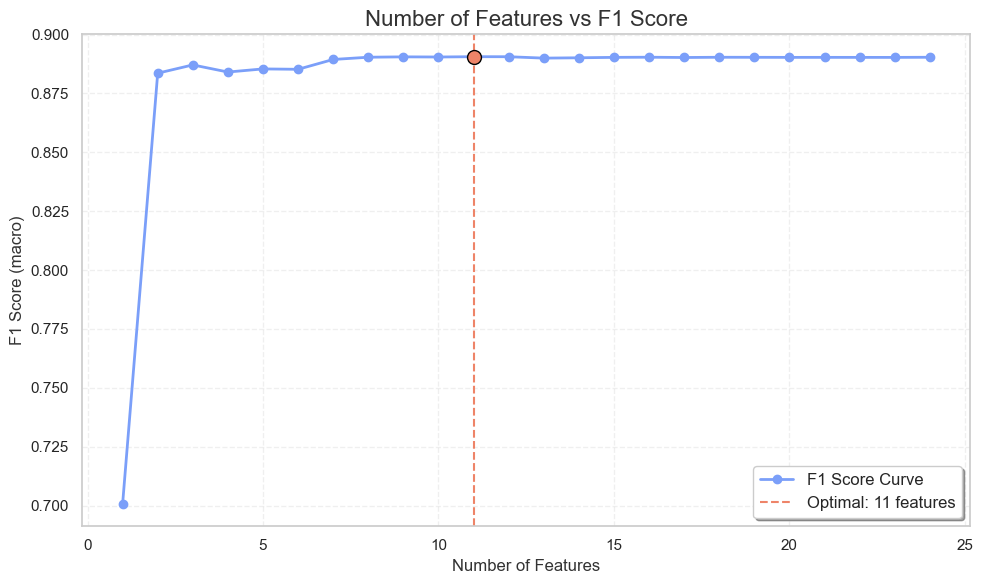

In [78]:
import matplotlib.pyplot as plt
import seaborn as sns

# Apply seaborn style for a cleaner look
sns.set(style='whitegrid')

# Define custom colors
line_color = sns.color_palette("coolwarm", as_cmap=True)(0.2)  # Cool blue
optimal_color = sns.color_palette("coolwarm", as_cmap=True)(0.8)  # Warm red

# Plot the number of features against the F1 scores
plt.figure(figsize=(10, 6))
plt.plot(feature_counts, scores, marker='o', linestyle='-', color=line_color, label='F1 Score Curve', linewidth=2)

# Highlight the optimal point
plt.axvline(x=best_n_features, color=optimal_color, linestyle='--', label=f'Optimal: {best_n_features} features', linewidth=1.5)
plt.scatter([best_n_features], [max(scores)], color=optimal_color, zorder=5, s=100, edgecolor='black')

# Add labels, title, and legend
plt.title('Number of Features vs F1 Score', fontsize=16, color="#333333")
plt.xlabel('Number of Features', fontsize=12, color="#333333")
plt.ylabel('F1 Score (macro)', fontsize=12, color="#333333")
plt.legend(frameon=True, shadow=True, fontsize=12)
plt.grid(alpha=0.3, linestyle='--')

# Show the plot
plt.tight_layout()
plt.show()


In [79]:
from sklearn.feature_selection import RFE
from sklearn.linear_model import LogisticRegression
import pandas as pd

# Assuming X_train_bin and y_train_bin are your features and target

# Step 1: Take a smaller sample (e.g., 10% of the data)
sample_size = int(0.5 * len(X_train_bin))  # 10% of the dataset
X_train_sample = X_train_bin.sample(n=sample_size, random_state=42)
y_train_sample = y_train_bin.sample(n=sample_size, random_state=42)

# Step 2: Initialize Logistic Regression
logistic_model = LogisticRegression(max_iter=1000, random_state=42)

# Step 3: Apply RFE to the sample data
rfe = RFE(logistic_model, n_features_to_select=11)  # Select top 8 features (adjust as needed)
rfe.fit(X_train_sample, y_train_sample)

# Step 4: Get the selected features
selected_features_rfe = X_train_sample.columns[rfe.support_]

# Print selected features
print("Selected Features after RFE with Logistic Regression:")
print(selected_features_rfe)

# Optionally, you can use the selected features to transform the dataset
X_train_selected_rfe = X_train_sample[selected_features_rfe]


Selected Features after RFE with Logistic Regression:
Index(['Attorney/Representative_binary', 'Carrier Type_State Insurance Fund',
       'First Hearing Date_nabinary', 'Average Weekly Wage_nabinary',
       'IME-4 Count', 'WCIO Cause of Injury Code_encoded_1',
       'WCIO Nature of Injury Code_encoded_1',
       'WCIO Part Of Body Code_encoded_1', 'WCIO Nature of Injury Code_freq',
       'Carrier Name_freq', 'Average Weekly Wage Imputed_log'],
      dtype='object')


In [80]:
from sklearn.linear_model import LassoCV
lasso = LassoCV(cv=5)  # Cross-validation to select optimal alpha
lasso.fit(X_train_bin, y_train_bin)
lasso_features = X_train_bin.columns[lasso.coef_ != 0]
print("Selected features by Lasso:", lasso_features)

Selected features by Lasso: Index(['Attorney/Representative_binary', 'Carrier Type_State Insurance Fund',
       'First Hearing Date_nabinary', 'C-3 Date_nabinary',
       'Average Weekly Wage_nabinary', 'Age at Injury', 'IME-4 Count',
       'Industry Code_encoded_1', 'WCIO Cause of Injury Code_encoded_1',
       'WCIO Nature of Injury Code_encoded_1',
       'WCIO Part Of Body Code_encoded_1', 'Industry Code_freq',
       'WCIO Cause of Injury Code_freq', 'WCIO Nature of Injury Code_freq',
       'WCIO Part Of Body Code_freq', 'Carrier Type Imputed_freq',
       'Carrier Name_freq', 'Days_between_Assembly Date_Accident Date_log',
       'Average Weekly Wage Imputed_log'],
      dtype='object')


In [81]:
from sklearn.linear_model import RidgeCV
import numpy as np

# Initialize Ridge regression model with cross-validation
ridge_model = RidgeCV(cv=5)

# Fit the model on the training data
ridge_model.fit(X_train_bin, y_train_bin)

# Get the feature coefficients
coefficients = ridge_model.coef_

# Set a threshold to select features (e.g., absolute coefficient > 0.01)
threshold = 0.001
ridge_features = X_train_bin.columns[np.abs(coefficients) > threshold]

print(f"Selected features using Ridge regression: {ridge_features}")


Selected features using Ridge regression: Index(['Attorney/Representative_binary', 'Carrier Type_State Insurance Fund',
       'First Hearing Date_nabinary', 'C-3 Date_nabinary',
       'Average Weekly Wage_nabinary', 'Age at Injury', 'IME-4 Count',
       'Industry Code_encoded_1', 'WCIO Cause of Injury Code_encoded_1',
       'WCIO Nature of Injury Code_encoded_1',
       'WCIO Part Of Body Code_encoded_1', 'Industry Code_freq',
       'WCIO Cause of Injury Code_freq', 'WCIO Nature of Injury Code_freq',
       'WCIO Part Of Body Code_freq', 'Carrier Type Imputed_freq',
       'Carrier Name_freq', 'Days_between_Assembly Date_Accident Date_log',
       'Average Weekly Wage Imputed_log'],
      dtype='object')


In [84]:
from sklearn.ensemble import RandomForestClassifier

# Initialize the Random Forest Classifier
rf_model = RandomForestClassifier(n_estimators=100, random_state=47)

# Fit the model on X_train and y_train_encoded
rf_model.fit(X_train_bin, y_train_bin)

# Get feature importances
importances = rf_model.feature_importances_

# Sort feature importances in descending order
important_indices = importances.argsort()[::-1]

# Print the feature importances
print("Feature importances:", importances)
print("Sorted feature indices:", important_indices)


Feature importances: [0.05881585 0.00220738 0.04942971 0.02412719 0.23847265 0.05811821
 0.08010243 0.01907469 0.02881951 0.01990763 0.02730619 0.01810478
 0.02355741 0.01296906 0.02333782 0.00760047 0.04093534 0.05613349
 0.21098017]
Sorted feature indices: [ 4 18  6  0  5 17  2 16  8 10  3 12 14  9  7 11 13 15  1]


In [86]:
import numpy as np

# Calculate cumulative sum of feature importances
cumulative_importance = np.cumsum(importances[important_indices])

# Find the index where cumulative importance exceeds 90%
threshold = 0.90
index_90 = np.argmax(cumulative_importance >= threshold)

# The number of features that explain 90% of the importance
num_features_90 = index_90 + 1  # Adding 1 since index starts at 0

print(f"Number of features explaining 90% of cumulative importance: {num_features_90}")

# Select the top features based on this number
random_forest_features = X_train_bin.columns[important_indices[:num_features_90]]
print(f"Selected features that explain 90% of cumulative importance: {random_forest_features}")


Number of features explaining 90% of cumulative importance: 13
Selected features that explain 90% of cumulative importance: Index(['Average Weekly Wage_nabinary', 'Average Weekly Wage Imputed_log',
       'IME-4 Count', 'Attorney/Representative_binary', 'Age at Injury',
       'Days_between_Assembly Date_Accident Date_log',
       'First Hearing Date_nabinary', 'Carrier Name_freq',
       'WCIO Cause of Injury Code_encoded_1',
       'WCIO Part Of Body Code_encoded_1', 'C-3 Date_nabinary',
       'WCIO Cause of Injury Code_freq', 'WCIO Part Of Body Code_freq'],
      dtype='object')


In [93]:
# Convert all feature sets to sets
rfe_set = set(selected_features_rfe)
lasso_set = set(lasso_features)
ridge_set = set(ridge_features)
rf_set = set(random_forest_features)

# Find features selected by at least three methods
final_features_set = (
    (lasso_set & rfe_set & ridge_set) |
    (lasso_set & ridge_set & rf_set) |
    (ridge_set & rfe_set & rf_set)
)

# Convert the final features set to a list (optional, for easier use later)
final_features = list(final_features_set)

# Print the selected features
print(len(final_features))
print("Features selected by at least three methods:")
final_features


16
Features selected by at least three methods:


['WCIO Part Of Body Code_freq',
 'First Hearing Date_nabinary',
 'WCIO Nature of Injury Code_freq',
 'WCIO Nature of Injury Code_encoded_1',
 'WCIO Part Of Body Code_encoded_1',
 'C-3 Date_nabinary',
 'WCIO Cause of Injury Code_freq',
 'Days_between_Assembly Date_Accident Date_log',
 'Average Weekly Wage_nabinary',
 'Attorney/Representative_binary',
 'IME-4 Count',
 'Carrier Name_freq',
 'Average Weekly Wage Imputed_log',
 'Carrier Type_State Insurance Fund',
 'Age at Injury',
 'WCIO Cause of Injury Code_encoded_1']

In [94]:
X_train_bin_filter = X_train_bin[final_features]
X_val_bin_filter = X_val_bin[final_features]
X_test_bin_filter = X_test_bin[final_features]

## 5. Binary: Model

In [95]:
def custom_loss(y_pred, dtrain):
    """
    Custom loss function penalizing false negatives for class 0.
    Parameters:
    - y_pred: Predicted values (log-odds).
    - dtrain: DMatrix containing true labels.

    Returns:
    - grad: Gradient of the loss.
    - hess: Hessian of the loss.
    """
    y_true = dtrain.get_label()  # Extract true labels from DMatrix
    y_pred = 1 / (1 + np.exp(-y_pred))  # Convert log-odds to probabilities

    # Adjust weights for class 0
    weight = np.where(y_true == 0, 2.0, 1.0)  # Double penalty for class 0 FN

    grad = (y_pred - y_true) * weight  # Gradient
    hess = y_pred * (1 - y_pred) * weight  # Hessian
    return grad, hess


In [96]:
import xgboost as xgb

# Convert data to DMatrix format
dtrain = xgb.DMatrix(X_train_bin_filter, label=y_train_bin)
dval = xgb.DMatrix(X_val_bin_filter, label=y_val_bin)

# Parameters for XGBoost
params = {
    "objective": "binary:logistic",  # Use binary classification
    "eval_metric": "logloss",  # Standard evaluation metric
    "eta": 0.1,  # Learning rate
    "max_depth": 6,  # Maximum depth of trees
}

# Train the model with custom loss function
model = xgb.train(
    params,
    dtrain,
    num_boost_round=100,
    obj=custom_loss,  # Custom loss function
    evals=[(dval, "validation")],
    early_stopping_rounds=10,  # Stop if no improvement
)


[0]	validation-logloss:0.63551
[1]	validation-logloss:0.58788
[2]	validation-logloss:0.54813
[3]	validation-logloss:0.51453
[4]	validation-logloss:0.48581
[5]	validation-logloss:0.46127
[6]	validation-logloss:0.43999
[7]	validation-logloss:0.42155
[8]	validation-logloss:0.40544
[9]	validation-logloss:0.39135
[10]	validation-logloss:0.37896
[11]	validation-logloss:0.36808
[12]	validation-logloss:0.35838
[13]	validation-logloss:0.34987
[14]	validation-logloss:0.34231
[15]	validation-logloss:0.33555
[16]	validation-logloss:0.32956
[17]	validation-logloss:0.32415
[18]	validation-logloss:0.31940
[19]	validation-logloss:0.31505
[20]	validation-logloss:0.31119
[21]	validation-logloss:0.30755
[22]	validation-logloss:0.30446
[23]	validation-logloss:0.30171
[24]	validation-logloss:0.29928
[25]	validation-logloss:0.29701
[26]	validation-logloss:0.29484
[27]	validation-logloss:0.29309
[28]	validation-logloss:0.29150
[29]	validation-logloss:0.28995
[30]	validation-logloss:0.28854
[31]	validation-lo

In [ ]:
# Predict probabilities
y_proba = model.predict(xgb.DMatrix(X_val_bin_filter))

# Convert probabilities to binary predictions using a threshold (default is 0.5)
threshold = 0.5
y_pred = (y_proba > threshold).astype(int)

# Evaluate
from sklearn.metrics import classification_report, accuracy_score, f1_score

print("Accuracy:", accuracy_score(y_val_bin, y_pred))
print("F1 Score:", f1_score(y_val_bin, y_pred, average="macro"))
print(classification_report(y_val_bin, y_pred))


Accuracy: 0.8944250871080139
F1 Score: 0.8942472260381943
              precision    recall  f1-score   support

           0       0.92      0.87      0.89     84881
           1       0.88      0.92      0.90     87319

    accuracy                           0.89    172200
   macro avg       0.90      0.89      0.89    172200
weighted avg       0.90      0.89      0.89    172200



In [100]:
import xgboost as xgb

model = xgb.XGBClassifier(eval_metric="mlogloss")
model.fit(X_train_bin_filter, y_train_bin)

# 3. Make predictions
y_pred = model.predict(X_val_bin_filter)  # Assuming X_test is available


# Evaluate the model
accuracy = accuracy_score(y_val_bin, y_pred)
f1_macro = f1_score(y_val_bin, y_pred, average='macro')  # Macro-averaged F1 score

# Print individual model results
print(f"XGBClassifier Accuracy: {accuracy:.4f}")
print(f"XGBClassifier Macro F1 Score: {f1_macro:.4f}")
print(classification_report(y_val_bin, y_pred))  # Detailed report including precision, recall, and F1 score per class
print("-" * 50)

XGBClassifier Accuracy: 0.9016
XGBClassifier Macro F1 Score: 0.9009
              precision    recall  f1-score   support

           0       0.96      0.83      0.89     84881
           1       0.86      0.97      0.91     87319

    accuracy                           0.90    172200
   macro avg       0.91      0.90      0.90    172200
weighted avg       0.91      0.90      0.90    172200

--------------------------------------------------


In [ ]:
import xgboost as xgb

model = xgb.XGBClassifier(eval_metric="mlogloss")
model.fit(X_train_bin_filter, y_train_bin)

# 3. Make predictions
y_pred = model.predict(X_val_bin_filter)  # Assuming X_test is available


# Evaluate the model
accuracy = accuracy_score(y_val_bin, y_pred)
f1_macro = f1_score(y_val_bin, y_pred, average='macro')  # Macro-averaged F1 score

# Print individual model results
print(f"XGBClassifier Accuracy: {accuracy:.4f}")
print(f"XGBClassifier Macro F1 Score: {f1_macro:.4f}")
print(classification_report(y_val_bin, y_pred))  # Detailed report including precision, recall, and F1 score per class
print("-" * 50)

## 6. Multiclass: Feature Selection

### 6.1 Filter Categorical Features

#### 6.1.1 Chi-square & Cramer's V

In [106]:
# Perform Chi-square test
chi2_values, p_values = chi2(X_train_cat, y_train_squeezed)

# Create DataFrame for Chi-square results
chi2_results = pd.DataFrame({
    'Column': X_train_cat.columns,
    'Chi2': chi2_values.round(5),
    'p-value': p_values.round(5)
})

# Calculate Cramér's V for binary target
cramers_v_values = []
for var in X_train_cat.columns:
    v = cramers_v(X_train_cat[var], y_train_squeezed)
    cramers_v_values.append(v)

# Add Cramér's V to DataFrame
chi2_results['Cramér\'s V'] = cramers_v_values

# Filter important features
chi2_important_features = chi2_results[(chi2_results['p-value'] < 0.05) & (chi2_results['Cramér\'s V'] >= 0.1)]

list_features_chi2_cramer = chi2_important_features['Column'].values

print(chi2_important_features)

                                     Column          Chi2  p-value  Cramér's V
1   Carrier Type_Self-insured Public Entity    5883.41625      0.0    0.137481
3         Carrier Type_State Insurance Fund    4741.97596      0.0    0.121874
5                         C-3 Date_nabinary   29753.82707      0.0    0.479025
6              Average Weekly Wage_nabinary  110326.13914      0.0    0.872155
7               First Hearing Date_nabinary   30991.88712      0.0    0.545735
10           Attorney/Representative_binary  102697.45907      0.0    0.614944


#### 6.1.2 Mutual Information

In [108]:
from sklearn.feature_selection import mutual_info_classif

# Calculate mutual information for categorical features
mi_scores = mutual_info_classif(X_train_cat, y_train_squeezed, discrete_features=True)

# Create DataFrame of results
mi_results = pd.DataFrame({
    'Feature': X_train_cat.columns,
    'Mutual Information': mi_scores
}).sort_values(by='Mutual Information', ascending=False)

mi_results

mi_important_features = mi_results[mi_results['Mutual Information'] > 0.05]

list_features_mi = mi_results[mi_results['Mutual Information'] > 0.05]['Feature'].values

print(mi_important_features)

                           Feature  Mutual Information
6     Average Weekly Wage_nabinary            0.469901
10  Attorney/Representative_binary            0.202553
7      First Hearing Date_nabinary            0.159525
5                C-3 Date_nabinary            0.117598


In [112]:
# Select features that appear in at least one of the important feature sets
selected_features = list(set(list_features_chi2_cramer) | set(list_features_mi)) 
print(selected_features)

# Keep only selected important features in the datasets
X_train_cat_filtered = X_train_cat[selected_features]
X_val_cat_filtered = X_val_cat[selected_features]
X_test_cat_filtered = X_test_cat[selected_features]

['Attorney/Representative_binary', 'Carrier Type_Self-insured Public Entity', 'First Hearing Date_nabinary', 'Carrier Type_State Insurance Fund', 'C-3 Date_nabinary', 'Average Weekly Wage_nabinary']


### 6.2 Filter Numerical

#### 6.2.1 Univariate variance

In [113]:
X_train_num_scaled.var().sort_values(ascending=False)

Accident Date_Season_Summer                           0.190598
Accident Date_Season_Winter                           0.190024
Accident Date_Season_Spring                           0.181228
Average Weekly Wage Imputed_log                       0.158004
Carrier Name_freq                                     0.142667
WCIO Nature of Injury Code_freq                       0.136735
Industry Code_freq                                    0.123001
Industry Code_encoded_5. PPD SCH LOSS                 0.114505
Number of Dependents                                  0.111300
Carrier Type Imputed_freq                             0.103530
Accident Datemonth                                    0.099293
WCIO Part Of Body Code_freq                           0.098325
WCIO Cause of Injury Code_freq                        0.080853
Industry Code_encoded_4. TEMPORARY                    0.063998
WCIO Nature of Injury Code_encoded_4. TEMPORARY       0.039304
Age at Injury                                         0

> No features with variance zero. Don't drop any here.

#### 6.2.2 Spearman Correlation

In [115]:
# Step 1: Calculate the Spearman correlation matrix for numerical features
cor_spearman = X_train_num_scaled.corr(method='spearman')

# Step 2: Flatten the correlation matrix and reset the index
correlation_pairs = cor_spearman.unstack().reset_index()

# Step 3: Rename columns for clarity
correlation_pairs.columns = ['Feature_1', 'Feature_2', 'Correlation']

# Step 4: Filter the table for correlations > 0.8 or < -0.8 and exclude self-correlations (diagonal)
strong_correlations = correlation_pairs[
    ((correlation_pairs['Correlation'] > 0.9) | (correlation_pairs['Correlation'] < -0.9)) & 
    (correlation_pairs['Feature_1'] != correlation_pairs['Feature_2'])
]

# Step 5: Remove duplicate pairs by keeping only one order
strong_correlations = strong_correlations[
    strong_correlations['Feature_1'] < strong_correlations['Feature_2']
]

# Step 6: Sort by correlation value
strong_correlations = strong_correlations.sort_values(by='Correlation', ascending=False)

# Step 7: Display the table
strong_correlations


,Feature_1,Feature_2,Correlation
1846,Days_between_Assembly Date_Accident Date_log,Days_between_C-2 Date Imputed_Accident Date_log,0.954048
